# Project 4 (Capstone Project): Analyzing COVID 19 Pandemic (ICU Prediction)
*Predicting ICU Admission for COVID-19 Patients (CRISP-DM Workflow)*


## 1. Business Understanding



In [ ]:
# placeholder ...


### 1.1 Problem Statement
During the COVID-19 pandemic, hospitals in Brazil and worldwide faced severe pressure on ICU capacity. ICU beds, staff and equipment are limited, and a surge of critical patients can quickly overwhelm the system. Clinicians need support to identify, as early as possible, which newly admitted COVID-19 patients are likely to require intensive care.


In [ ]:
# placeholder ...


### 1.2 Project Objectives
The goal of this project is to build a machine learning model that predicts whether a confirmed COVID-19 patient will be admitted to the ICU during their hospital stay, using clinical information available shortly after admission. This can help hospitals:
- Prioritize high-risk patients for closer monitoring,
- Plan ICU bed allocation in advance,
- Support decisions about patient transfer to higher-complexity centers.

In [ ]:
# placeholder ...


### 1.3 Success Criteria

From a data-science perspective:
- F1 score ≥ target
- Achieve a strong **F1-score** on a held-out test set (balancing precision and recall).
- Avoid data leakage by using only information available **before** ICU admission.
- Provide interpretable insights into which clinical features are associated with ICU admission.

From a clinical/operational perspective:
- The model should flag high-risk patients early enough (e.g. using the first time window) to be actionable.
- The false-negative rate (missed ICU cases) should be low enough to be acceptable in a triage context.

In [ ]:
# placeholder ...



## 2. Data Understanding


### 2.1 Dataset Overview
*(Insert dataset description summary)*

In [ ]:
# placeholder ...

### 2.2 Load the Dataset


In [7]:
# load necessary libraries ...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style
sns.set_theme(style="whitegrid")

# Load dataset (update path if needed)
df = pd.read_excel("./data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
df.head(15)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


### 2.3 Inspect Structure


In [8]:
# Basic information about the dataset
df.info()
df.describe()
df.isnull().sum()

# Shape of the dataset (rows, columns)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


(1925, 231)

#### Interpretation of Dataset Structure

The dataset contains 1,925 rows and 231 columns. Most columns are continuous clinical measurements already scaled between -1 and 1, with a small number of identifier or categorical fields.  

A large number of features per patient encounter is typical in clinical datasets, especially when laboratory values are expanded into summary statistics (mean, median, max, min, diff, relative diff).  

No obvious structural issues (e.g., malformed columns or inconsistent dtypes) were observed.  
This confirms that the dataset is clean and ready for exploratory analysis.


#### 2.3.1 Inspect Time Window and Target Variables
In addition to basic dataset structure, it is important to understand:
- how many samples exist in each time window (`WINDOW`), and  
- the class distribution of the target variable (`ICU`).

This helps assess class imbalance and confirms the temporal structure of the dataset.


In [9]:
# Inspect distribution of time windows
df['WINDOW'].value_counts().sort_index()

WINDOW
0-2         385
2-4         385
4-6         385
6-12        385
ABOVE_12    385
Name: count, dtype: int64

#### Interpretation of Time Window Distribution

Each of the five clinical time windows (0–2h, 2–4h, 4–6h, 6–12h, and 12+ hours) contains exactly 385 observations.  
This balanced distribution confirms that the dataset was intentionally constructed so each patient-time window is equally represented.

Because ICU admission could occur at any point during hospitalization, using measurements from windows **at or after** the ICU event could introduce data leakage.  
This will be addressed during the cohort selection and Data Preparation steps.


#### 2.3.2 Examine ICU Class Distribution
The target variable `ICU` indicates whether a patient was admitted to the ICU.
Understanding the frequency and balance of this variable is critical before modeling.


ICU Counts:
 ICU
0    1410
1     515
Name: count, dtype: int64

ICU Percentages:
 ICU
0    73.246753
1    26.753247
Name: proportion, dtype: float64


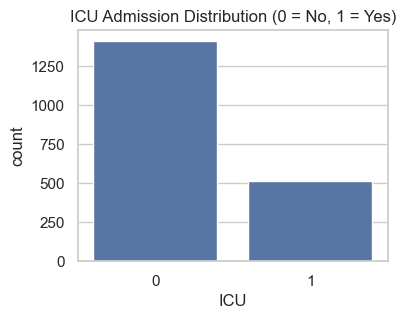

In [10]:
# Check ICU target class distribution
icu_counts = df['ICU'].value_counts()
icu_percent = df['ICU'].value_counts(normalize=True) * 100

print("ICU Counts:\n", icu_counts)
print("\nICU Percentages:\n", icu_percent)

# Simple bar plot for target balance
plt.figure(figsize=(4,3))
sns.countplot(x='ICU', data=df)
plt.title('ICU Admission Distribution (0 = No, 1 = Yes)')
plt.show()


##### Interpretation of ICU Class Balance

The target variable is imbalanced, with approximately 27% ICU admissions and 73% non-ICU cases.  
This imbalance is moderate and typical in clinical prediction problems.

As a result, accuracy alone is not a reliable performance metric.  
We will emphasize **F1-score**, **precision**, **recall**, and confusion-matrix–based interpretation when evaluating model performance.  

During modeling, we may also consider techniques such as:
- class_weight adjustments  
- balanced random forests  
- or oversampling methods (e.g., SMOTE)

depending on baseline model performance.


### 2.4 Initial Observations
- The dataset contains **~1,900 patient–window records** with over **200 clinical features**, including demographics, comorbidities, blood tests, vital signs, and blood gases.
- The **ICU** column is a binary target indicating whether the patient was admitted to the ICU (1) or not (0). The classes are imbalanced, with fewer ICU admissions than non-ICU cases.
- The **WINDOW** column encodes time since hospital admission in 5 discrete windows (0–2h, 2–4h, 4–6h, 6–12h, 12+ hours). Each patient may appear in multiple windows.
- According to the dataset description, features were already **scaled using a Min-Max scaler to the range [-1, 1]**, so no additional global scaling is required unless new features are engineered.
- In later steps we must ensure that only measurements **before ICU admission** are used as model inputs to avoid temporal data leakage.
- Overall, the dataset appears structurally sound and ready for further exploratory data analysis.


In [ ]:
# placeholder ...



### 2.5 Target Variable Analysis
- Distribution of ICU admissions
- Class balance plot


In [ ]:
# placeholder ...



### 2.6 Windows & Cohort Selection


In [ ]:
# placeholder ...


#### 2.6.1 Understanding Time Windows

- Each row corresponds to a patient-time window: \
  0–2h, 2–4h, 4–6h, 6–12h, 12+ hours after hospital admission.
- ICU admission may occur at any time window.
- Clinical relevance: Earlier windows (0–2) are the most valuable for prediction.

In [ ]:
# placeholder ...


#### 2.6.2 Identifying Windows Containing or Occurring After ICU Admission
*(Insert code to check whether any time windows occur at or after ICU admission.)*
- These windows must not be used as features.
- We remove all rows from windows at or after ICU admission.

In [ ]:
# placeholder ...


#### 2.6.3 Selecting the Training Cohort

There are two valid modeling strategies:


In [ ]:
# placeholder ...


##### Strategy A: EARLY-ONLY MODEL
Use only the 0–2 hour window for prediction.
- Clinically relevant
- Faster modeling
- Less leakage risk
- Useful for emergency triage

In [ ]:
# placeholder ...


##### Strategy B: MULTI-WINDOW MODEL (but only pre-ICU windows)

Use all windows before ICU admission.
- More data
- Possibly better F1 score
- Must be careful about correlated repeated measures

For this project, we will pick one strategy during Data Preparation.
(Bootcamp-friendly → Strategy A is simple, clean, defensible.)

In [ ]:
# placeholder ...


#### 2.6.4 Markdown Placeholder: Decision Rationale
*(Here you will later write your explanation of why you chose your cohort.)*


In [ ]:
# placeholder ...


## 3. Exploratory Data Analysis (EDA)


In [ ]:
# placeholder ...


### 3.1 Univariate Analysis
- Histograms (continuous features)
- Bar plots (categorical features)
- Identify skew, outliers


In [ ]:
# placeholder ...


### 3.2 Bivariate Analysis
- ICU vs features (boxplots, barplots)


In [ ]:
# placeholder ...


### 3.3 Correlation Analysis
- Correlation matrix
- Heatmaps
- Identify collinearity


In [ ]:
# placeholder ...


### 3.4 Key Insights from EDA
*(Insert narrative summary)*


In [ ]:
# placeholder ...


## 4. Data Preparation


In [ ]:
# placeholder ...

### 4.1 Handle Missing Values
*(Document choices; imputation strategies)*


In [ ]:
# placeholder ...


### 4.2 Feature Engineering
- Scaling
- Encoding
- Interaction terms (if any)
- Remove highly correlated features (if needed)


In [ ]:
# placeholder ...


### 4.3 Train-Test Split


In [ ]:
# Split the dataset into features and target variable
from sklearn.model_selection import train_test_split

X = df.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 5. Modeling


In [ ]:
# placeholder ...


### 5.1 Baseline Model — Logistic Regression
- Fit model
- Predict
- Evaluate


In [ ]:
# placeholder ...


### 5.2 Model 2 — Random Forest
- Fit
- Predict
- Evaluate


In [ ]:
# placeholder ...

### 5.3 Optional Model 3 — XGBoost (if needed)
- Fit
- Predict
- Evaluate


In [ ]:
# placeholder ...


### 5.4 Compare Model Performance
*(Insert comparison table: precision, recall, F1)*


In [ ]:
# placeholder ...


## 6. Hyperparameter Tuning


In [ ]:
# placeholder ...


### 6.1 Select Model to Tune
*(Likely RandomForest or XGBoost)*


In [ ]:
# placeholder ...


### 6.2 Perform Tuning


In [ ]:
# import GridSearchCV to perform hyperparameter tuning ...
from sklearn.model_selection import GridSearchCV

# grid search skeleton


### 6.3 Evaluate Tuned Model
*(Insert evaluation metrics)*


In [ ]:
# placeholder ...


### 6.4 Final Model Selection
*(Choose based on F1 and interpretability)*


In [ ]:
# placeholder ...


## 7. Evaluation


In [6]:
# placeholder ...


### 7.1 Classification Report


In [ ]:
# placeholder ...


### 7.2 Confusion Matrix


In [ ]:
# placeholder ...


### 7.3 ROC Curve + AUC


In [ ]:
# placeholder ...


### 7.4 Key Insights
- Where does the model succeed?
- Where does it struggle?


In [ ]:
# placeholder ...


## 8. Feature Importance


In [ ]:
# placeholder ...


### 8.1 Model-Based Feature Importance


In [ ]:
# placeholder ...


### 8.2 SHAP (optional if time allows)


In [ ]:
# placeholder ...


## 9. Conclusion & Next Steps


In [ ]:
# placeholder ...


### 9.1 Summary of Findings


In [ ]:
# placeholder ...


### 9.2 Model Use in Hospital Setting


In [ ]:
# placeholder ...


### 9.3 Limitations


In [ ]:
# placeholder ...


### 9.4 Future Work

In [ ]:
# placeholder ...


# 10

In [ ]:
# placeholder ...
